# Bandit QNN FL in IRIS dataset

 This algorithm is a QFL framework that allow clients to use greedy policy to interact with environment. It is implemented in a simple task dataset, in whose scenario the client can get feedback, and use the feedback as part of the new training dataset, to allow them converge in an uncertain environment. 

## Load IRIS dataset

In [3]:
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
maternal_health_risk = fetch_ucirepo(id=863) 
  
# data (as pandas dataframes) 
features = maternal_health_risk.data.features 
labels = maternal_health_risk.data.targets 
  
  
# variable information 
print(maternal_health_risk.variables) 

print(features,labels)

          name     role         type demographic  \
0          Age  Feature      Integer         Age   
1   SystolicBP  Feature      Integer        None   
2  DiastolicBP  Feature      Integer        None   
3           BS  Feature      Integer        None   
4     BodyTemp  Feature      Integer        None   
5    HeartRate  Feature      Integer        None   
6    RiskLevel   Target  Categorical        None   

                                         description   units missing_values  
0    Any ages in years when a women during pregnant.    None             no  
1  Upper value of Blood Pressure in mmHg, another...    None             no  
2  Lower value of Blood Pressure in mmHg, another...    None             no  
3  Blood glucose levels is in terms of a molar co...  mmol/L             no  
4                                               None       F             no  
5                        A normal resting heart rate     bpm             no  
6  Predicted Risk Intensity Level dur

Firstly, we'll normalize the features. Namely, we will apply a simple transformation to represent all features on the same scale. In our case, we squeeze all features onto the interval $[0, 1]$. Normalization is a common technique in machine learning and often leads to better numerical stability and convergence of an algorithm.

We can use `MinMaxScaler` from scikit-learn to perform this. Without specifying parameters, this does exactly what is required: maps data onto $[0, 1]$.

In [69]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)
# print(features)

Let's see how our data looks. We plot the features pair-wise to see if there's an observable correlation between them.

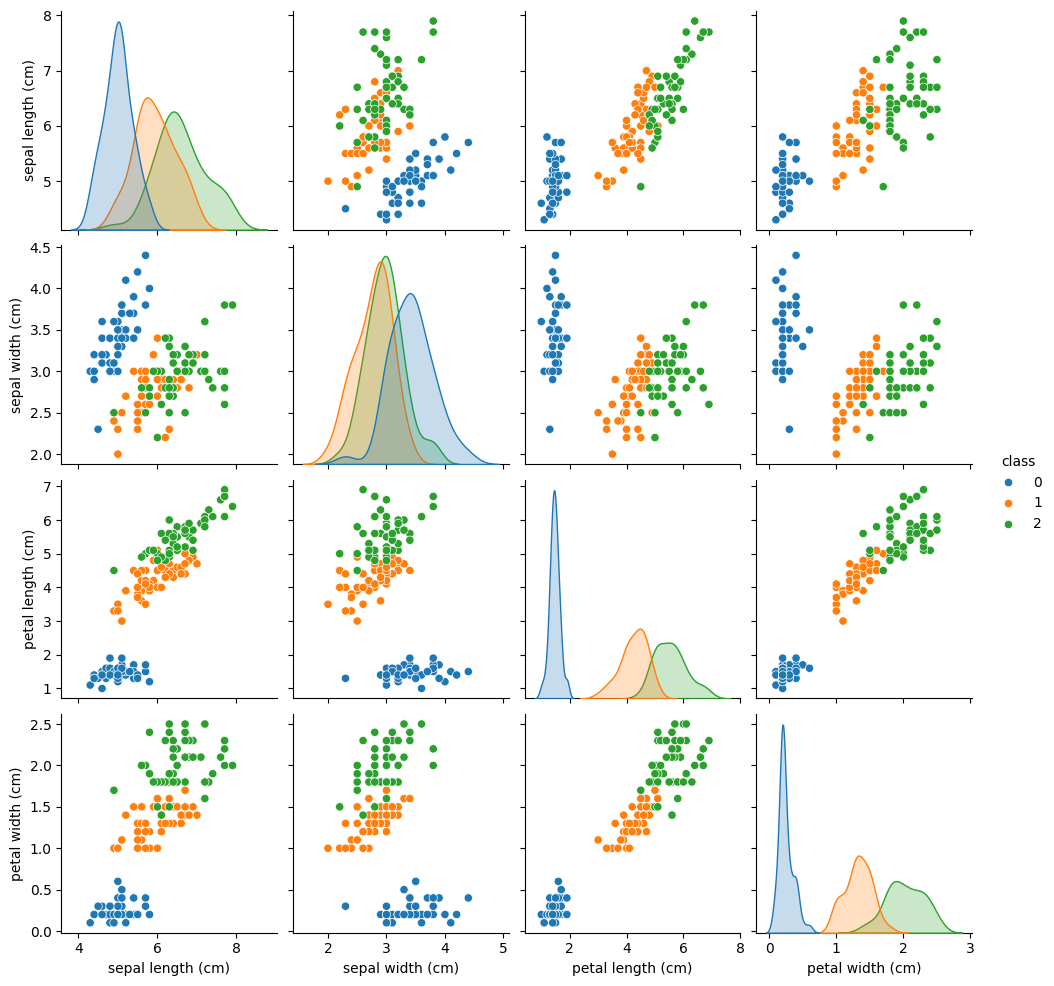

In [70]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

From the plots, we see that class `0` is easily separable from the other two classes, while classes `1` and `2` are sometimes intertwined, especially regarding the "sepal width" feature.

Next, we use QNN to handle this dataset. 

## Training with QNN

Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. We'll use the former to train the model and the latter to verify how well our models perform on unseen data.

As usual, we'll ask scikit-learn to do the boring job for us. We'll also fix the seed to ensure the results are reproducible.

In [71]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)
print(train_features[:5], test_features[:5], train_labels[:5], test_labels[:5])
train_set = []
test_set = []
for i in range(len(train_features)):
    train = {'sequence': train_features[i], 'label': train_labels[i]}
    train_set.append(train)
for i in range(len(test_features)):
    test = {'sequence': test_features[i], 'label': test_labels[i]}
    test_set.append(test)
print(train_set)

[[0.86111111 0.33333333 0.86440678 0.75      ]
 [0.47222222 0.08333333 0.6779661  0.58333333]
 [0.11111111 0.5        0.10169492 0.04166667]
 [0.22222222 0.625      0.06779661 0.04166667]
 [0.47222222 0.08333333 0.50847458 0.375     ]] [[0.55555556 0.20833333 0.66101695 0.58333333]
 [0.69444444 0.41666667 0.76271186 0.83333333]
 [0.58333333 0.33333333 0.77966102 0.875     ]
 [0.36111111 0.41666667 0.52542373 0.5       ]
 [0.16666667 0.66666667 0.06779661 0.        ]] [2 2 0 0 1] [1 2 2 1 0]
[{'sequence': array([0.86111111, 0.33333333, 0.86440678, 0.75      ]), 'label': 2}, {'sequence': array([0.47222222, 0.08333333, 0.6779661 , 0.58333333]), 'label': 2}, {'sequence': array([0.11111111, 0.5       , 0.10169492, 0.04166667]), 'label': 0}, {'sequence': array([0.22222222, 0.625     , 0.06779661, 0.04166667]), 'label': 0}, {'sequence': array([0.47222222, 0.08333333, 0.50847458, 0.375     ]), 'label': 1}, {'sequence': array([0.19444444, 0.125     , 0.38983051, 0.375     ]), 'label': 1}, {'seq

Once the data is loaded, we must immediately apply a parameterized quantum circuit. This circuit is a direct analog to the layers in classical neural networks. It has a set of tunable parameters or weights. The weights are optimized such that they minimize an objective function. This objective function characterizes the distance between the predictions and known labeled data. A parameterized quantum circuit is also called a parameterized trial state, variational form, or ansatz. Perhaps, the latter is the most widely used term.

## Use QNN 
design a qnn circuit, which use 2 qubits, 4 inputs and 4 weights

input parameters: ['input[0]', 'input[1]', 'input[2]', 'input[3]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


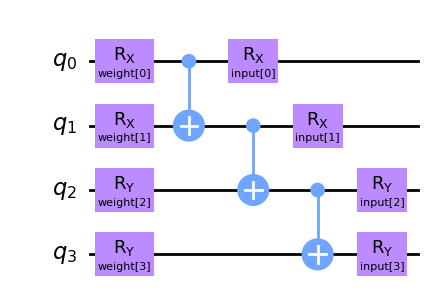

In [72]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
inputs = ParameterVector("input", 4)
weights = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs.params]}")
print(f"weight parameters: {[str(item) for item in weights.params]}")

qc = QuantumCircuit(4)
qc.rx(weights[0], 0)
qc.rx(weights[1], 1)
qc.ry(weights[2], 2)
qc.ry(weights[3], 3)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.rx(inputs[0], 0)
qc.rx(inputs[1], 1)
qc.ry(inputs[2], 2)
qc.ry(inputs[3], 3)


qc.draw("mpl", style="clifford")

Use a callback function to draw a histogram

In [73]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Define interpret function to map 4 outputs into 3 categories. Instantiate samplerQNN and NeutralNetworkClassifier.

In [74]:
import time
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import GradientDescent
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import BackendSampler       
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler
import qiskit_aer.noise as noise

## Quantum Noise

In [75]:
backend = AerSimulator()

noise_model = NoiseModel.from_backend(backend)
print(noise_model)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map


NoiseModel: Ideal


d:\Software\Anaconda2022.10\envs\qfl\lib\site-packages\qiskit_aer\noise\noise_model.py:377: UserWarning: Qiskit backend AerSimulator('aer_simulator') has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


### depolarizing noise model

In [76]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rx', 'ry'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

### Pauli noise model

In [77]:
from qiskit.circuit.library.standard_gates import XGate, YGate
from qiskit.quantum_info.operators import Pauli
x = XGate()
y = YGate()
noise_ops = [(Pauli(x),0.1),(Pauli(y),0.9)]
# Pauli quantum errors
error = noise.pauli_error(noise_ops)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['rx', 'ry'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

backend = AerSimulator(noise_model=noise_model,
                   coupling_map=coupling_map,
                   basis_gates=basis_gates)

In [78]:
def custom_interpreter(x):
    if 0 <= x <= 5:
        return 0
    elif 6 <= x <= 10:
        return 1
    else:
        return 2
output_shape = 3  # 0, 1, 2 one-hot encoding

optimizer = COBYLA(maxiter=50)
shots = 10000
sampler = Sampler(options={"shots": shots})
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=inputs,
    weight_params=weights,
    interpret=custom_interpreter,
    output_shape=output_shape,
    #sampler=sampler
    sampler = BackendSampler(backend=backend)
)

qnn = NeuralNetworkClassifier(
    sampler_qnn, 
    loss='squared_error', 
    one_hot=True, 
    optimizer=optimizer, 
    warm_start=True, 
    initial_point=None, 
    callback=callback_graph
    )

C:\Users\18706\AppData\Local\Temp\ipykernel_22676\3038559136.py:12: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={"shots": shots})
C:\Users\18706\AppData\Local\Temp\ipykernel_22676\3038559136.py:20: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend=backend)


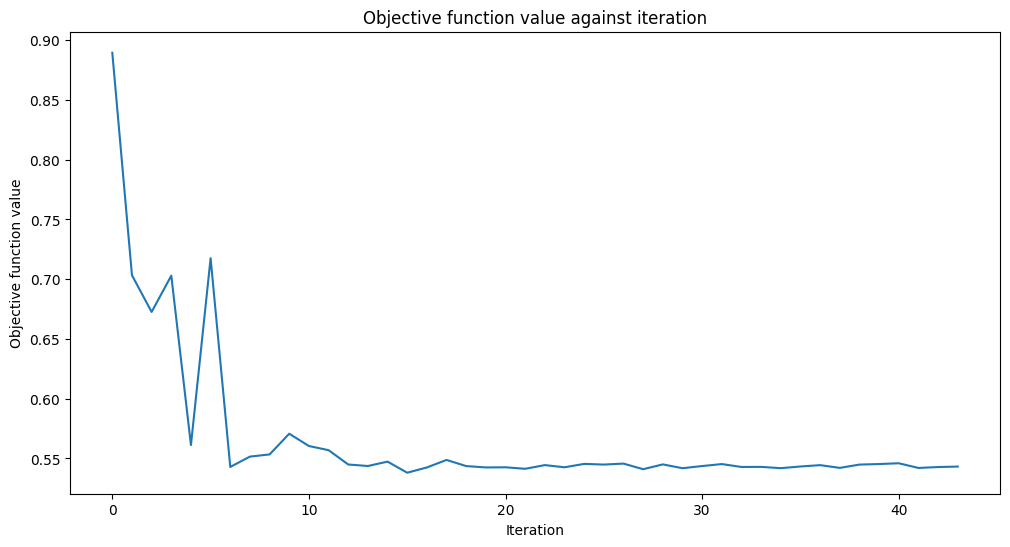

Training time: 29 seconds
0.8666666666666667
Precision: [1.         0.66666667 0.71428571]
Recall: [1.         0.33333333 0.90909091]
Quantum QNN on the training dataset: 0.72
Quantum QNN on the test dataset:     0.93


In [79]:
# clear objective value history
objective_func_vals = []

start = time.time()
qnn.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

print(qnn.score(test_features, test_labels, sample_weight=None))

train_score_q4 = qnn.score(train_features, train_labels)
test_score_q4 = qnn.score(test_features, test_labels)
pred_labels = qnn.predict(test_features)
assert test_labels.ndim == 1, "test_labels should be a 1D array"
precision = precision_score(test_labels, pred_labels,average=None)
print(f'Precision: {precision}')
recall = recall_score(test_labels, pred_labels,average=None)
print(f'Recall: {recall}')

print(f"Quantum QNN on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QNN on the test dataset:     {test_score_q4:.2f}")

## Environment Model: generating bandit data
Unlike before, we add an exploration module to this model. In the process of deploying the model, when the user uses the model, the model does not necessarily give the predicted label, but there is a certain probability that the model will give the user other labels. Generate a feedback record of whether the user approved of the tag. This feedback record includes input features, predicted labels, selected labels, and exploration probabilities.

The model starts with initial weights and is already ready to make predictions. Based on the input, it will produce a predicted output. Store the results of this model. During the midway process, the model can be optimized. The bandit algorithm is used to dynamically optimize the QFL model and explore the needs of users. The needs of users themselves will also change.

### Epsilon Greedy

In [80]:
import random
import collections
import tensorflow as tf
def epsilon_greedy_bandit_data(data,model,epsilon):
    train_sequences = [data_point["sequence"] for data_point in data]
    train_labels = [data_point["label"] for data_point in data]
    # Convert the lists to NumPy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    arms_num = 3
    #模型预测值
    pred_action = model.predict(train_sequences)
    # get predicted vector in logits way
    logits = sampler_qnn.forward(train_sequences, model.weights)
    action_list = []
    reward_list = []
    prob_list = []
    arr = [0,1,2]
    print("Inference Started")
    for i in range(len(pred_action)):
        t =  random.random()
        if t < epsilon:
            remaining_action = [x for x in arr if x != pred_action[i]]
            action = random.choice(remaining_action)
            #print(action)
        else:
            action = pred_action[i]
            #print(action)
        action_list.append(action)

        if action == train_labels[i]:
            reward = 1
        else:
            reward = 0
        reward_list.append(reward)

        action_match_pred = (action_list[i]==pred_action[i])
        per_action_epsilon = epsilon / tf.cast(arms_num, dtype=tf.float32)
        prob = (1 - epsilon + per_action_epsilon) * action_match_pred + (
          1.0 - action_match_pred) * per_action_epsilon
        prob_list.append(prob)
    print("Inference Completed")
    
    action_logits = tf.gather(logits, action_list, axis=1, batch_dims=1).numpy()
    print(logits[:10])
    weight_scale = tf.math.minimum(
          1 - epsilon + per_action_epsilon, per_action_epsilon
      )
    new_y = collections.OrderedDict([
          ('label', pred_action), #预测的行为
          ('action', action_list),#实际做出的选择
          ('reward', reward_list),
          ('prob', prob_list),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
    bandits_data = collections.OrderedDict(x=train_sequences, y=new_y)
    
    return bandits_data

    
#bandits_data = epsilon_greedy_bandit_data(qnn,0.2)
#print(bandits_data['y'])




### Falcon

In [81]:
def falcon_bandit_data(data,model,mu,gamma):
  train_sequences = [data_point["sequence"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]
  # Convert the lists to NumPy arrays
  train_sequences = np.array(train_sequences)
  train_labels = np.array(train_labels)

  pred_action = model.predict(train_sequences)
  pred_logits = sampler_qnn.forward(train_sequences, model.weights)
  #print("pred_logits:",pred_logits)
  batch_size = tf.shape(pred_logits)[0]
  num_arms = tf.shape(pred_logits)[1]
  greedy_action = tf.argmax(pred_logits, axis=1, output_type=tf.int32)
  #print("greedy_action:",greedy_action)
  greedy_logits = tf.gather(pred_logits, greedy_action, axis=1, batch_dims=1)
  #print("greedy_logits:",greedy_logits)
  nongreedy_res = tf.expand_dims(greedy_logits, axis=1) - pred_logits
  #print("nongreedy_res:",nongreedy_res)
  nongreedy_prob = 1.0 / (mu + gamma * nongreedy_res)
  #print("nongreedy_prob:",nongreedy_prob)
  greedy_indicator = tf.one_hot(
      greedy_action, depth=num_arms, on_value=True, off_value=False
  )
  #print("greedy_indicator",greedy_indicator)
  nongreedy_prob = tf.where(
      greedy_indicator, tf.zeros_like(pred_logits), nongreedy_prob
  )
  #print("nongreedy_prob",nongreedy_prob)
  # Normalize nongreedy_prob if the sum of probablility is larger than 1 so that
  # it is still a probability distribution to be sampled even if mu and gamma
  # are not properly set.
  nongreedy_prob = nongreedy_prob / tf.math.maximum(
      1.0, tf.math.reduce_sum(nongreedy_prob, axis=1, keepdims=True)
  )
  greedy_prob = 1.0 - tf.math.reduce_sum(nongreedy_prob, axis=1)
  greedy_idx = tf.stack([tf.range(batch_size), greedy_action], axis=1)
  prob = (
      tf.scatter_nd(greedy_idx, greedy_prob, shape=tf.shape(pred_logits))
      + nongreedy_prob
  )
  cumsum_prob = tf.math.cumsum(prob, axis=1)
  cumsum_prob = tf.cast(cumsum_prob, dtype=tf.float32)
  # We can use tf.random.uniform for independent noise on clients, see
  # https://www.tensorflow.org/federated/tutorials/random_noise_generation
  random_val = tf.random.uniform(
      shape=[batch_size], minval=0, maxval=1, dtype=tf.float32
  )
  less_idx = tf.math.less(tf.expand_dims(random_val, axis=1), cumsum_prob)
  # The `action_helper` is constructed so that if the `cumsum_prob` is larger
  # than or equal to `random_val`, the values are the action index; if
  # `cumsum_prob` is smaller, the values are a constant number of the largest
  # possible index of action. When taking the min of `action_helper`,
  # the action where random_val falls in the `cumsum_prob` backet is returned;
  # i.e., the action is sampled based on the falcon `prob`.
  action_helper = tf.where(
      less_idx,
      tf.broadcast_to(
          tf.range(num_arms, dtype=tf.int32), shape=[batch_size, num_arms]
      ),
      (num_arms - 1) * tf.ones(shape=(batch_size, num_arms), dtype=tf.int32),
  )

  # bandit data
  action = tf.math.reduce_min(action_helper, axis=1).numpy()
  print("action:", action)
  action_prob = tf.gather(prob, action, axis=1, batch_dims=1).numpy()
  action_logits = tf.gather(pred_logits, action, axis=1, batch_dims=1).numpy()
  reward_list = []
  for i in range(batch_size):
    if action[i] == train_labels[i]:
        reward = 2
    else:
        reward = -1
    reward_list.append(reward)
  #print("reward:",reward_list)
  weight_scale = 1.0 / (mu + gamma)
  new_y = collections.OrderedDict([
          ('label', pred_action),#predicted action
          ('action', action),#actual action
          ('reward', reward_list),#comparation between correct action(test_label) and actual action
          ('prob', action_prob),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
  return collections.OrderedDict(x=train_sequences, y=new_y)


#bandits_data = falcon_bandit_data(train_set,qnn,0.5,10)
#print("----------------------------------------------------------------------")
#print(bandits_data['y'])


### Softmax Sampling

In [82]:
def softmax_sampling_bandit_data(data,model,temperature):
    train_sequences = [data_point["sequence"] for data_point in data]
    train_labels = [data_point["label"] for data_point in data]
    # Convert the lists to NumPy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    pred_action = model.predict(train_sequences)
    pred_logits = sampler_qnn.forward(train_sequences, model.weights)
    batch_size = tf.shape(pred_logits)[0]
    num_arms = tf.shape(pred_logits)[1]
    prob = tf.keras.activations.softmax(pred_logits/temperature, axis=-1)
    cumsum_prob = tf.math.cumsum(prob, axis=1)
    cumsum_prob = tf.cast(cumsum_prob, dtype=tf.float32)
    # We can use tf.random.uniform for independent noise on clients, see
    # https://www.tensorflow.org/federated/tutorials/random_noise_generation
    random_val = tf.random.uniform(
        shape=[batch_size], minval=0, maxval=1, dtype=tf.float32
    )
    less_idx = tf.math.less(tf.expand_dims(random_val, axis=1), cumsum_prob)
    # The `action_helper` is constructed so that if the `cumsum_prob` is larger
    # than or equal to `random_val`, the values are the action index; if
    # `cumsum_prob` is smaller, the values are a constant number of the largest
    # possible index of action. When taking the min of `action_helper`,
    # the action where random_val falls in the `cumsum_prob` backet is returned;
    # i.e., the action is sampled based on the softmax `prob`.
    action_helper = tf.where(
        less_idx,
        tf.broadcast_to(
            tf.range(num_arms, dtype=tf.int32), shape=[batch_size, num_arms]
        ),
        (num_arms - 1) * tf.ones(shape=(batch_size, num_arms), dtype=tf.int32),
    )
    action = tf.math.reduce_min(action_helper, axis=1).numpy()
    print("action:", action)
    action_prob = tf.gather(prob, action, axis=1, batch_dims=1).numpy()
    action_logits = tf.gather(pred_logits, action, axis=1, batch_dims=1).numpy()
    reward_list = []
    for i in range(batch_size):
        if action[i] == train_labels[i]:
            reward = 1
        else:
            reward = 0
        reward_list.append(reward)
    #print("reward:",reward_list)
    weight_scale = 1.0 
    new_y = collections.OrderedDict([
          ('label', pred_action),#predicted action
          ('action', action),#actual action
          ('reward', reward_list),#comparation between correct action(test_label) and actual action
          ('prob', action_prob),
          ('logits', action_logits),
          ('weight_scale', weight_scale),
      ])
    return collections.OrderedDict(x=train_sequences, y=new_y)


#bandits_data = softmax_sampling_bandit_data(qnn,0.05)
#print("----------------------------------------------------------------------")
#print(bandits_data)


## Implementing the Bandit in QNN
Use bandit data to train the QNN. Mainly change the loss function.

### Loss function with weights

In [83]:
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss,L2Loss,Loss
from qiskit_machine_learning.exceptions import QiskitMachineLearningError

#### Bandits absolute error

In [84]:

class L1Loss_w():
    r"""
    This class computes the L1 loss (i.e. absolute error) for each sample as:

    .. math::

        \text{L1Loss}(predict, target) = \sum_{i=0}^{N_{\text{elements}}} \left| predict_i -
        target_i \right|.
    """
    def __call__(self, predict: np.ndarray, target: np.ndarray,weights: np.ndarray = None) -> np.ndarray:
        """
        This method calls the ``evaluate`` method. This is a convenient method to compute loss.
        """
        return self.evaluate(predict, target, weights)

    def evaluate(self, predict: np.ndarray, target: np.ndarray,weights: np.ndarray = None) -> np.ndarray:
        self._validate_shapes(predict, target)
        if weights is None:
            if len(predict.shape) <= 1:
                return np.abs(predict - target)
            else:
                return np.linalg.norm(predict - target, ord=1, axis=tuple(range(1, len(predict.shape))))
        else:
            if len(predict.shape) <= 1:
                return np.abs(predict - target)*weights
            else:
                return np.linalg.norm(predict - target, ord=1, axis=tuple(range(1, len(predict.shape))))*weights

    def gradient(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:
        self._validate_shapes(predict, target)

        return np.sign(predict - target)
    @staticmethod
    def _validate_shapes(predict: np.ndarray, target: np.ndarray) -> None:
        """
        Validates that shapes of both parameters are identical.

        Args:
            predict: an array of predicted values using the model
            target: an array of the true values

        Raises:
            QiskitMachineLearningError: shapes of predict and target do not match.
        """

        if predict.shape != target.shape:
            raise QiskitMachineLearningError(
                f"Shapes don't match, predict: {predict.shape}, target: {target.shape}!"
            )

#### Bandits mean square error loss

In [85]:
class L2Loss_w():
    r"""
    This class computes the L2 loss (i.e. squared error) for each sample as:

    .. math::

        \text{L2Loss}(predict, target) = \sum_{i=0}^{N_{\text{elements}}} (predict_i - target_i)^2.

    """
    def __call__(self, predict: np.ndarray, target: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
        """
        This method calls the ``evaluate`` method. This is a convenient method to compute loss.
        """
        return self.evaluate(predict, target, weights)
    def evaluate(self, predict: np.ndarray, target: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
        self._validate_shapes(predict, target)
        if weights is None:
            if len(predict.shape) <= 1:
                return (predict - target) ** 2
            else:
                return np.linalg.norm(predict - target, axis=tuple(range(1, len(predict.shape)))) ** 2
        else:
            if len(predict.shape) <= 1:
                return weights*(predict - target) ** 2 
            else:
                return weights*np.linalg.norm(predict - target, axis=tuple(range(1, len(predict.shape)))) ** 2 

    def gradient(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:
        self._validate_shapes(predict, target)

        return 2 * (predict - target)
    @staticmethod
    def _validate_shapes(predict: np.ndarray, target: np.ndarray) -> None:
        """
        Validates that shapes of both parameters are identical.

        Args:
            predict: an array of predicted values using the model
            target: an array of the true values

        Raises:
            QiskitMachineLearningError: shapes of predict and target do not match.
        """

        if predict.shape != target.shape:
            raise QiskitMachineLearningError(
                f"Shapes don't match, predict: {predict.shape}, target: {target.shape}!"
            )

#### Bandits cross entropy loss

In [86]:
class CrossEntropyLoss():
    r"""
    This class computes the cross entropy loss for each sample as:

    .. math::

        \text{CrossEntropyLoss}(predict, target) = -\sum_{i=0}^{N_{\text{classes}}}
        target_i * log(predict_i).
    """
    def __call__(self, predict: np.ndarray, target: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
        """
        This method calls the ``evaluate`` method. This is a convenient method to compute loss.
        """
        return self.evaluate(predict, target, weights)
    def evaluate(self, predict: np.ndarray, target: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
        self._validate_shapes(predict, target)
        if len(predict.shape) == 1:
            predict = predict.reshape(1, -1)
            target = target.reshape(1, -1)

        # multiply target and log(predict) matrices row by row and sum up each row
        # into a single float, so the output is of shape(N,), where N number or samples.
        # then reshape
        # before taking the log we clip the predicted probabilities at a small positive number. This
        # ensures that in cases where a class is predicted to have 0 probability we don't get `nan`.
        val = -np.einsum(
            "ij,ij->i", target, np.log2(np.clip(predict, a_min=1e-10, a_max=None))
        ).reshape(-1, 1)
        return val*weights

    def gradient(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:
        """Assume softmax is used, and target vector may or may not be one-hot encoding"""

        self._validate_shapes(predict, target)
        if len(predict.shape) == 1:
            predict = predict.reshape(1, -1)
            target = target.reshape(1, -1)

        # sum up target along rows, then multiply predict by this sum element wise,
        # then subtract target
        grad = np.einsum("ij,i->ij", predict, np.sum(target, axis=1)) - target

        return grad
    @staticmethod
    def _validate_shapes(predict: np.ndarray, target: np.ndarray) -> None:
        """
        Validates that shapes of both parameters are identical.

        Args:
            predict: an array of predicted values using the model
            target: an array of the true values

        Raises:
            QiskitMachineLearningError: shapes of predict and target do not match.
        """

        if predict.shape != target.shape:
            raise QiskitMachineLearningError(
                f"Shapes don't match, predict: {predict.shape}, target: {target.shape}!"
            )

### Bandit Process

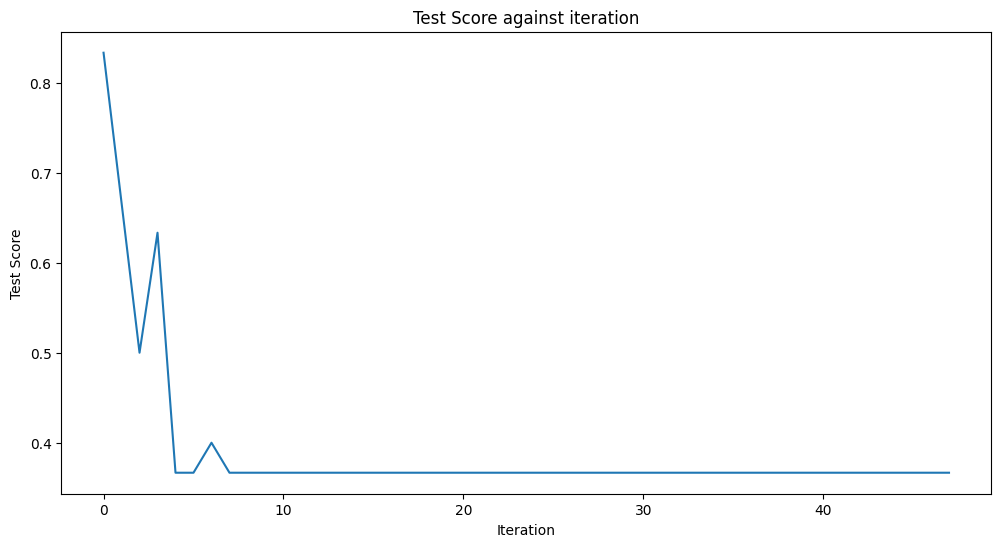

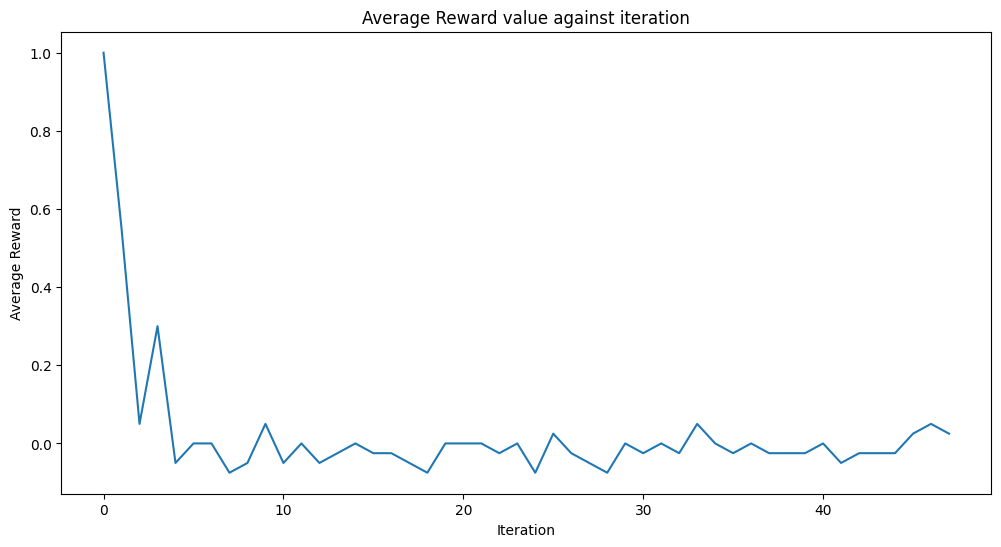

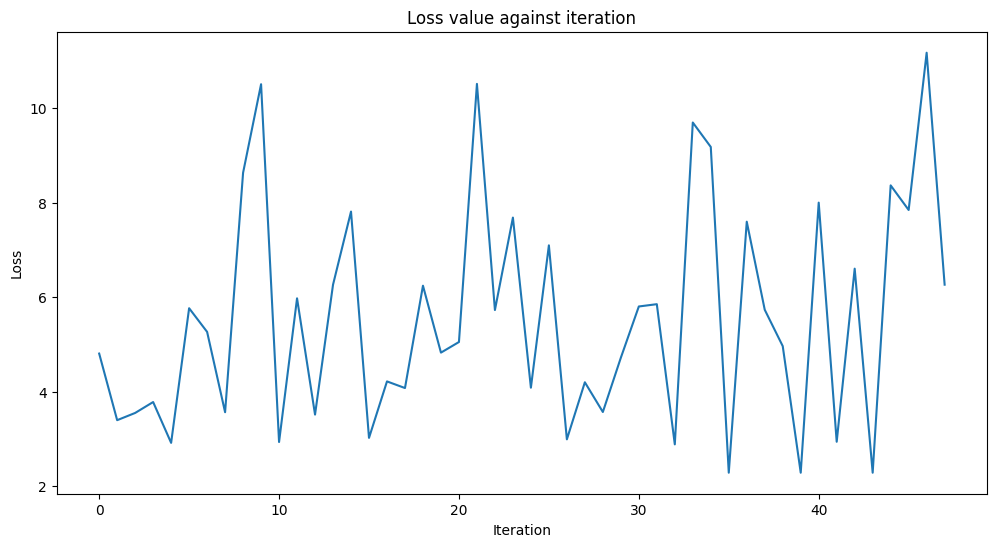

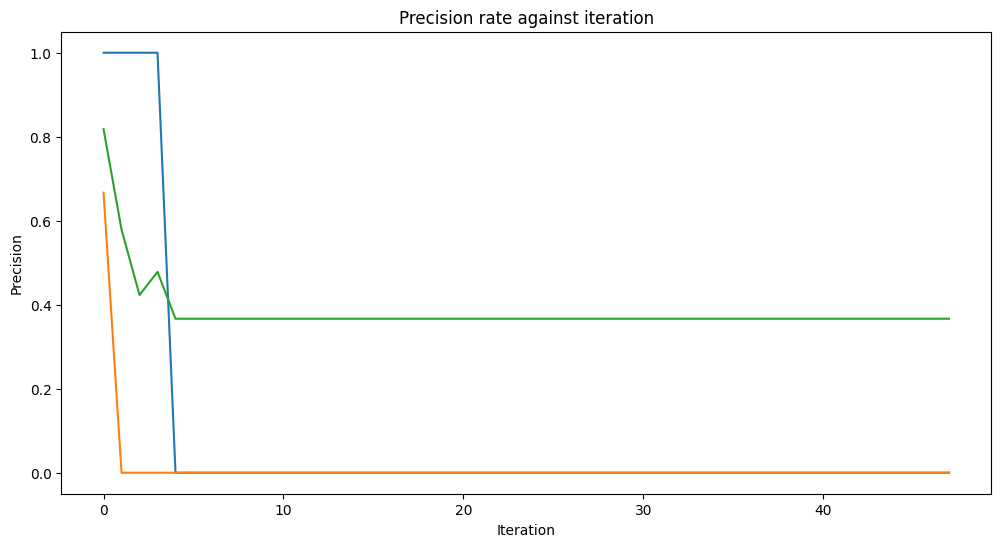

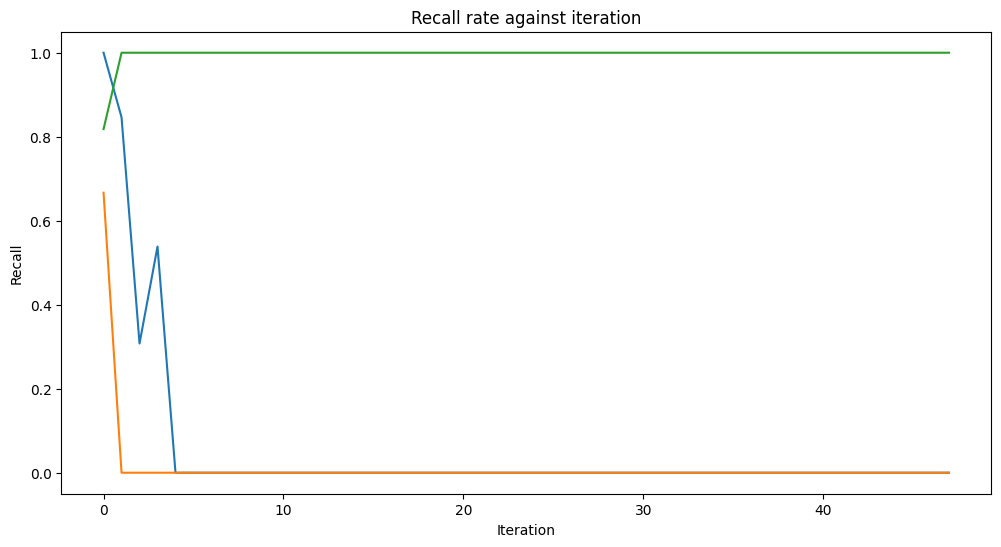

In [87]:
import time
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import GradientDescent
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
import numpy as np
scoreList = []
rewardList = []
lossList = []
precisionList = []
recallList = []
def callback_bandit(score,reward,loss,precision,recall):
    clear_output(wait=True)
    scoreList.append(score)
    plt.title("Test Score against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Test Score")
    plt.plot(range(len(scoreList)), scoreList)
    plt.show()

    rewardList.append(reward)
    plt.title("Average Reward value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.plot(range(len(rewardList)), rewardList)
    plt.show()

    lossList.append(loss)
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(lossList)), lossList)
    plt.show()

    precisionList.append(precision)
    plt.title("Precision rate against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Precision")
    plt.plot(range(len(precisionList)), precisionList)
    plt.show()

    recallList.append(recall)
    plt.title("Recall rate against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Recall")
    plt.plot(range(len(recallList)), recallList)
    plt.show()

def banditLoss(weights):
    qnn.fit_result.x = weights
    # epsilon greedy
    #bandits_data = epsilon_greedy_bandit_data(train_set,qnn,0.1)
    # falcon
    bandits_data = falcon_bandit_data(train_set,qnn,60,100)
    # softmax sampling
    #bandits_data = softmax_sampling_bandit_data(train_set,qnn,0.05)
    
    logits = np.array(bandits_data['y']['prob'])
    reward = np.array(bandits_data['y']['reward'])
    sum_reward=float(sum(reward))
    prob = np.array(bandits_data['y']['prob'])
    weight_scale = np.array(bandits_data['y']['weight_scale'])
    sample_weights =  weight_scale / prob
    #label = np.array(bandits_data['y']['label'])

    #cross entropy loss
    #loss_function = CrossEntropyLoss()
    #loss = loss_function(logits, reward, sample_weights)
    #loss_item = float(np.squeeze(loss))
    #print("Loss:", loss_item)

    #squared error
    loss_function = L2Loss_w()
    loss = loss_function(logits, reward,sample_weights)
    loss_item = sum(loss)
    #print("Loss:", loss_item)

    #squared error
    #loss_function = L1Loss_w()
    #loss = loss_function(logits,reward,sample_weights)
    #loss_item = sum(loss)
    print("Loss_5:", loss_item)
    print("logits:",logits)
    print("reward_avg:",sum(reward)/len(reward))
    
    print("Score:", qnn.score(test_features, test_labels))
    print("sum_reward:",sum_reward)
   
    score = qnn.score(test_features, test_labels)
    pred_labels = qnn.predict(test_features)
    precision = precision_score(test_labels, pred_labels,average=None)
    print(f'Precision: {precision}')
    recall = recall_score(test_labels, pred_labels,average=None)
    print(f'Recall: {recall}')
    avg_reward = sum_reward/len(reward)
    callback_bandit(score,avg_reward,loss_item,precision,recall)
    return loss_item

#optimizer = GradientDescent(maxiter=100, learning_rate=0.01)
optimizer = COBYLA(maxiter=100)
fit_result = optimizer.minimize(fun=banditLoss, x0=qnn.weights)

qnn.fit_result.x = fit_result.x




In [88]:
import statistics
pred_labels = qnn.predict(test_features)
precision = precision_score(test_labels, pred_labels,average=None)
print(f'Precision: {precision}')
recall = recall_score(test_labels, pred_labels,average=None)
print(f'Recall: {recall}')
for i in range(len(precision)):
    values = [precision[i],recall[i]]
    h_mean = statistics.harmonic_mean(values)
    print(f'Harmonic Mean(F1){i}: {h_mean}')
bandits_data = falcon_bandit_data(train_set,qnn,60,100)
reward = np.array(bandits_data['y']['reward'])
sum_reward=float(sum(reward))
avg_reward=sum_reward/len(reward)
#print(np.array(bandits_data['y']))
print(f'Average Reward: {avg_reward}')


d:\Software\Anaconda2022.10\envs\qfl\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Software\Anaconda2022.10\envs\qfl\lib\statistics.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1 / x for x in _fail_neg(data, errmsg))


Precision: [0.         0.         0.36666667]
Recall: [0. 0. 1.]
Harmonic Mean(F1)0: 0.0
Harmonic Mean(F1)1: 0.0
Harmonic Mean(F1)2: 0.5365853658536585
action: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
Average Reward: -0.025


In [102]:
print(qnn.score(test_features, test_labels, sample_weight=None))

train_score_q4 = qnn.score(train_features, train_labels)
test_score_q4 = qnn.score(test_features, test_labels)

print(f"Quantum QNN on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QNN on the test dataset:     {test_score_q4:.2f}")

print(qnn.weights)

0.36666666666666664
Quantum QNN on the training dataset: 0.33
Quantum QNN on the test dataset:     0.37
[2.23016699 1.12678577 0.09848776 2.47913311]


## Configuring the Federated Learning Setup

In this code section, we establish essential variables and settings for our Federated Learning setup. These variables play a crucial role in shaping how the Federated Learning process unfolds and offer the flexibility to customize the experiment to meet specific requirements.

Here, we outline the key variables that we define:

- `num_clients`: This variable determines the number of participating clients in our Federated Learning setup. Each client plays a role in the learning process.
- `num_epochs`: It specifies the number of training epochs, indicating how many times the Federated Learning process will iterate through the training data for each client.
- `max_train_iterations`: This variable controls the maximum number of training iterations that each client will perform during each round of Federated Learning.
- `samples_per_epoch`: It defines the number of samples processed in each training epoch for each client.
- `backend`: The choice of backend, specified as 'aer_simulator' in this code, determines the quantum simulator used for the Federated Learning setup. If you intend to work with a real quantum device, you can replace this backend with a real quantum device backend provided by IBM Quantum.

It's important to note that you can adjust these values as needed, depending on your specific use case and testing requirements. However, there is a critical constraint to consider: Ensure that the size of the `np_train_data` dataset is less than or equal to the product of `num_clients`, `num_epochs`, and `samples_per_epoch`. This constraint ensures that there is sufficient data to split between each client.


In [90]:
num_clients = 3
num_epochs = 5
max_train_iterations = 40
samples_per_epoch=8

pretrain_itr = 0
server_itr = 0


class Client:
    def __init__(self, data):
        self.models = []
        self.primary_model = None
        self.data = data
        self.test_scores = []
        self.train_scores = []
        self.avg_reward = []

def split_dataset(num_clients, num_epochs, samples_per_epoch):
  clients = []
  for i in range(num_clients):
    client_data = []
    for j in range(num_epochs):
      start_idx = (i*num_epochs*samples_per_epoch)+(j*samples_per_epoch)
      end_idx = (i*num_epochs*samples_per_epoch)+((j+1)*samples_per_epoch)
      print(start_idx, end_idx)
      client_data.append(train_set[start_idx:end_idx])
    clients.append(Client(client_data))
  return clients

clients = split_dataset(num_clients, num_epochs, samples_per_epoch)
print(clients[2].data)



0 8
8 16
16 24
24 32
32 40
40 48
48 56
56 64
64 72
72 80
80 88
88 96
96 104
104 112
112 120
[[{'sequence': array([0.47222222, 0.58333333, 0.59322034, 0.625     ]), 'label': 1}, {'sequence': array([0.52777778, 0.375     , 0.55932203, 0.5       ]), 'label': 1}, {'sequence': array([0.77777778, 0.41666667, 0.83050847, 0.83333333]), 'label': 2}, {'sequence': array([0.72222222, 0.45833333, 0.66101695, 0.58333333]), 'label': 1}, {'sequence': array([0.41666667, 0.25      , 0.50847458, 0.45833333]), 'label': 1}, {'sequence': array([0.38888889, 0.33333333, 0.52542373, 0.5       ]), 'label': 1}, {'sequence': array([0.91666667, 0.41666667, 0.94915254, 0.83333333]), 'label': 2}, {'sequence': array([0.19444444, 0.58333333, 0.08474576, 0.04166667]), 'label': 0}], [{'sequence': array([0.27777778, 0.70833333, 0.08474576, 0.04166667]), 'label': 0}, {'sequence': array([0.44444444, 0.41666667, 0.54237288, 0.58333333]), 'label': 1}, {'sequence': array([0.72222222, 0.5       , 0.79661017, 0.91666667]), 'lab

## Training Function

In [91]:
import time

itr = 0  
def callback_itr(weights, obj_func_eval):
    global itr
    itr += 1
    print(f"{itr}", end=' | ')
    

def train(data, model = None):
  train_sequences = [data_point["sequence"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]
  # Convert the lists to NumPy arrays
  train_sequences = np.array(train_sequences)
  train_labels = np.array(train_labels)

  # Print the shapes
  print("Train Sequences Shape:", train_sequences.shape)
  print("Train Labels Shape:", train_labels.shape)


  if model is None:
    #optimizer = COBYLA(maxiter=max_train_iterations)
    optimizer = COBYLA(maxiter=pretrain_itr)
    sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=inputs,
    weight_params=weights,
    interpret=custom_interpreter,
    output_shape=output_shape,
    sampler = BackendSampler(backend=backend)
    )
    qnn = NeuralNetworkClassifier(
        sampler_qnn, 
        loss='squared_error', 
        one_hot=True, 
        optimizer=optimizer, 
        warm_start=True, 
        initial_point=None, 
        callback=callback_graph
    )
    model = qnn
    model.fit(train_sequences, train_labels)
    #model.fit_result.x = [0.91698094, 3.82355225, 0.62690029, 1.53121652]

  
  def clientBanditLoss(weights):
    model.fit_result.x = weights
    # epsilon greedy
    #bandits_data = epsilon_greedy_bandit_data(qnn,0.05)
    # falcon
    bandits_data = falcon_bandit_data(data,model,60,100)
    # softmax sampling
    #bandits_data = softmax_sampling_bandit_data(qnn,0.05)
    
    logits = np.array(bandits_data['y']['logits'])
    reward = np.array(bandits_data['y']['reward'])
    sum_reward=float(sum(reward))
    prob = np.array(bandits_data['y']['prob'])
    weight_scale = np.array(bandits_data['y']['weight_scale'])
    sample_weights =  weight_scale / prob
   
    loss_function = L1Loss_w()
    loss = loss_function(logits,reward,sample_weights)
    loss_item = sum(loss)
    print("Loss_5:", loss_item)
    print("logits:",logits)
    print("reward_avg:",sum(reward)/len(reward))
    
    print("Score:", model.score(test_features, test_labels))
    print("sum_reward:",sum_reward)

    return loss_item

  print("Training Started")
  start_time = time.time()
  #model.fit(train_sequences, train_labels)
  #optimizer = GradientDescent(maxiter=max_train_iterations, learning_rate=0.001)
  optimizer = COBYLA(maxiter=max_train_iterations)
  fit_result = optimizer.minimize(fun=clientBanditLoss, x0=model.weights)
  model.fit_result.x = fit_result.x
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

  print(f"SCORING MODEL")
  train_score_q = model.score(train_sequences, train_labels)
  test_score_q = model.score(test_features, test_labels)
  return train_score_q, test_score_q, model



## Model Accuracy and Creation Functions

In the provided code, two essential functions are defined, each with a specific role.

**`getAccuracy` Function**:
- The `getAccuracy` function calculates and returns the accuracy of a model with given weights. It initializes a Quantum Variational Circuit (QVC) model with the provided weights and prepares it for evaluation. While it includes a call to the training function (`vqc.fit()`), the training itself doesn't occur because we set the maximum iteration value of the optimizer to 0. This is done as a workaround because we cannot directly use the `.score` function without first executing the `.fit` function on a new VQC class instance. After model preparation, the function computes the accuracy by evaluating the model's performance using test sequences and labels.

**`create_model_with_weights` Function**:
- The `create_model_with_weights` function creates a new Quantum Variational Circuit (QVC) model with an initial point set to the given weights. This function is instrumental in creating a global model from global model weights during the Federated Learning training process.


In [92]:
from functools import partial
def getAccuracy(weights):
    optimizer = COBYLA(maxiter=0)
    qnn = NeuralNetworkClassifier(
        sampler_qnn, 
        loss='squared_error', 
        one_hot=True, 
        optimizer=optimizer, 
        warm_start=True, 
        initial_point=weights, 
    )
    qnn.fit(test_features[:25], test_labels[:25])
    return qnn.score(test_features, test_labels)

def getAvgReward(weights):
    optimizer = COBYLA(maxiter=0)
    qnn = NeuralNetworkClassifier(
        sampler_qnn, 
        loss='squared_error', 
        one_hot=True, 
        optimizer=optimizer, 
        warm_start=True, 
        initial_point=weights, 
    )
    qnn.fit(test_features[:25], test_labels[:25])
    qnn.fit_result.x=weights
    bandits_data = falcon_bandit_data(test_set,qnn,60,100)
    # softmax sampling
    #bandits_data = softmax_sampling_bandit_data(test_set,qnn,0.05)
    reward = np.array(bandits_data['y']['reward'])
    sum_reward=float(sum(reward))
    avg_reward=sum_reward/len(reward)
    return avg_reward

def create_model_with_weights(weights):
    optimizer = COBYLA(maxiter=server_itr)
    qnn = NeuralNetworkClassifier(
        sampler_qnn, 
        loss='squared_error', 
        one_hot=True, 
        optimizer=optimizer, 
        warm_start=True, 
        initial_point=weights, 
        callback=partial(callback_itr)
    )
    qnn.fit(train_features, train_labels)
    return qnn

In [93]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)

In [94]:
import numpy as np

def sort_epoch_results(epoch_results):
    # Pair weights and test_scores together
    pairs = zip(epoch_results['weights'], epoch_results['test_scores'])

    # Sort the pairs based on test_scores
    sorted_pairs = sorted(pairs, key=lambda x: x[1])

    # Unzip the sorted pairs back into separate arrays
    sorted_weights, sorted_test_scores = zip(*sorted_pairs)

    # Create a new sorted dictionary
    sorted_epoch_results = {
        'weights': list(sorted_weights),
        'test_scores': list(sorted_test_scores)
    }

    return sorted_epoch_results
fl_avg_weight_range = [0.1, 1]

def scale_test_scores(sorted_epoch_results):
    min_test_score = sorted_epoch_results['test_scores'][0]
    max_test_score = sorted_epoch_results['test_scores'][-1]
    min_weight, max_weight = fl_avg_weight_range
    if max_test_score != min_test_score:
      scaled_weights = [
          min_weight + (max_weight - min_weight) * (test_score - min_test_score) / (max_test_score - min_test_score)
          for test_score in sorted_epoch_results['test_scores']
      ]
    else:
      scaled_weights = [
          min_weight + (max_weight - min_weight) * (test_score - min_test_score) / 0.0001
          for test_score in sorted_epoch_results['test_scores']
      ]    
    sorted_epoch_results['fl_avg_weights'] = scaled_weights
    return sorted_epoch_results

def calculate_weighted_average(model_weights, fl_avg_weights):
    weighted_sum_weights = []
    for index in range(len(model_weights[0])):
      weighted_sum_weights.append(0)
      weighted_sum_weights[index] = sum([(weights_array[index]* avg_weight) for weights_array, avg_weight  in zip(model_weights, fl_avg_weights)])/sum(fl_avg_weights)
    return weighted_sum_weights

def weighted_average(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)
  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)
  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch



def weighted_average_best_pick(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None, best_pick_cutoff = 0.5):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)

  new_weights = []
  new_test_scores = []
  new_fl_avg_weights = []

  for index, fl_avg_weight in enumerate(epoch_results['fl_avg_weights']):
      if fl_avg_weight >= best_pick_cutoff:
          new_weights.append(epoch_results['weights'][index])
          new_test_scores.append(epoch_results['test_scores'][index])
          new_fl_avg_weights.append(fl_avg_weight)

  # Update the epoch_results dictionary with the new lists
  epoch_results['weights'] = new_weights
  epoch_results['test_scores'] = new_test_scores
  epoch_results['fl_avg_weights'] = new_fl_avg_weights

  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch

def simple_averaging(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_weights = epoch_results['weights']
  averages = []
  # Iterate through the columns (i.e., elements at the same position) of the arrays
  for col in range(len(epoch_weights[0])):
      # Initialize a variable to store the sum of elements at the same position
      col_sum = 0
      for row in range(len(epoch_weights)):
          col_sum += epoch_weights[row][col]

      # Calculate the average for this column and append it to the averages list
      col_avg = col_sum / len(epoch_weights)
      averages.append(col_avg)

  return averages

# Example usage:
# epoch_results = {
#     'weights': [[1.4, 1.1, 1.6], [1.3, 1.2, 1.5], [1.2, 1.4, 1.5], [1.4, 1.1, 1.6], [1.5, 1.0, 1.7]],
#     'test_scores': [95, 55, 12, 6, 3, 2]
# }

# fl_avg_weight_range = [0.1, 1]

# weight_avg = weighted_average(epoch_results)
# print(weight_avg)

# weight_avg_bp = weighted_average_best_pick(epoch_results)
# print(weight_avg_bp)

# averaging = simple_averaging(epoch_results)
# print(averaging)
# Create a dictionary mapping function names to their corresponding functions


In [95]:
fl_techniques = {
    'Averaging': simple_averaging,
    'Weighted_Averaging': weighted_average,
    'Best_Pick_Weighted_Averaging': weighted_average_best_pick
}
clients_2d_array = [[] for _ in range(len(fl_techniques))]

for index, (technique_name, _) in enumerate(fl_techniques.items()):
        for client in clients:
          client_copy = Client(client.data)
          clients_2d_array[index].append(client_copy)

In [96]:
clients_2d_array

[[<__main__.Client at 0x22cd541b190>,

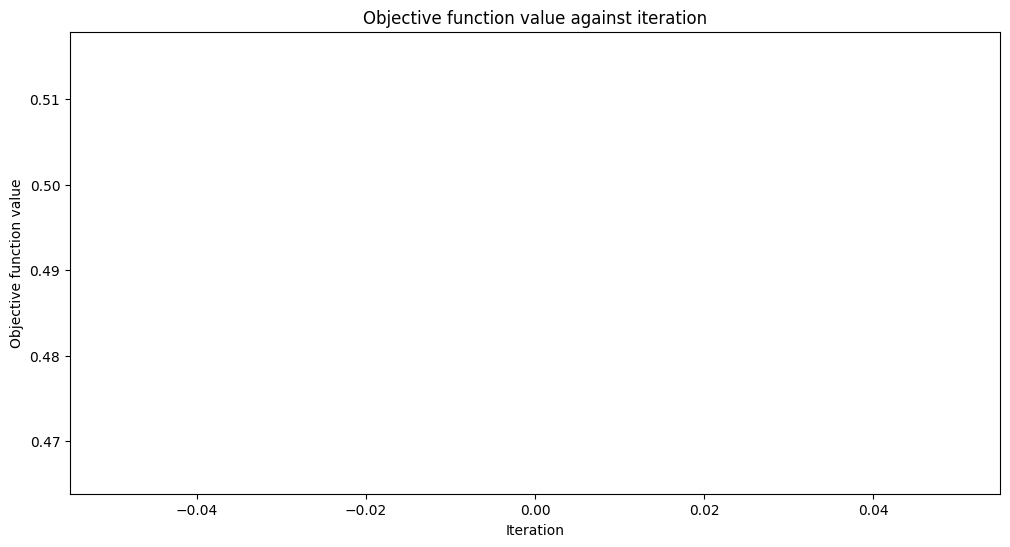

Training Started
action: [1 1 1 1 1 1 1 1]
Loss_5: 0.07390679006503739
logits: [0.6328125  0.62402344 0.52832031 0.57519531 0.64648438 0.64746094
 0.52929688 0.65625   ]
reward_avg: 0.875
Score: 0.2
sum_reward: 7.0
action: [0 0 0 0 0 0 0 0]
Loss_5: 0.072760900929836
logits: [0.39355469 0.41992188 0.36328125 0.41210938 0.44726562 0.41699219
 0.35253906 0.49121094]
reward_avg: -0.625
Score: 0.43333333333333335
sum_reward: -5.0
action: [2 2 2 2 2 2 2 0]
Loss_5: 0.07678959117768713
logits: [0.4921875  0.46289062 0.46777344 0.46289062 0.43945312 0.43066406
 0.45507812 0.39941406]
reward_avg: 0.125
Score: 0.7666666666666667
sum_reward: 1.0
action: [1 1 1 1 1 1 1 1]
Loss_5: 0.07615297593601175
logits: [0.54980469 0.53710938 0.57128906 0.55175781 0.54882812 0.5625
 0.57226562 0.52734375]
reward_avg: 0.875
Score: 0.2
sum_reward: 7.0
action: [2 2 2 2 2 2 2 0]
Loss_5: 0.07573712390124288
logits: [0.44824219 0.41894531 0.44921875 0.45800781 0.43261719 0.44238281
 0.47851562 0.46875   ]
reward_avg:

In [97]:
global_model_weights = []
global_model_accuracy = []
global_model_avg_reward = []


for outer_idx, clients in enumerate(clients_2d_array):
  technique_name = list(fl_techniques.keys())[outer_idx]
  technique_function = list(fl_techniques.values())[outer_idx]
  print(f"Technique Name: {technique_name}")
  global_model_weights.append([])
  global_model_accuracy.append([])
  global_model_avg_reward.append([])
  for epoch in range(num_epochs):
    epoch_results = {
        'weights': [],
        'test_scores': [],
        'avg_reward': []
    }
    print(f"epoch: {epoch}")

    for index, client in enumerate(clients):
      print(f"Index: {index}, Client: {client}")

      objective_func_vals = []

      if client.primary_model is None:
        train_score_q, test_score_q, model = train(data = client.data[epoch])
        avg_reward = getAvgReward(model.weights)
        client.models.append(model)
        client.test_scores.append(test_score_q)
        client.train_scores.append(train_score_q)
        client.avg_reward.append(avg_reward)

        # Print the values
        print("Train Score:", train_score_q)
        print("Test Score:", test_score_q)
        print("\n\n")
        epoch_results['weights'].append(model.weights)
        epoch_results['test_scores'].append(test_score_q)
        epoch_results['avg_reward'].append(avg_reward)

      else:
        train_score_q, test_score_q, model = train(data = client.data[epoch], model = client.primary_model)
        avg_reward = getAvgReward(model.weights)
        client.models.append(model)
        client.test_scores.append(test_score_q)
        client.train_scores.append(train_score_q)
        client.avg_reward.append(avg_reward)
        print("Train Score:", train_score_q)
        print("Test Score:", test_score_q)
        print("\n\n")
        epoch_results['weights'].append(model.weights)
        epoch_results['test_scores'].append(test_score_q)
        epoch_results['avg_reward'].append(avg_reward)

    new_global_weights = []
    if(epoch == 0):
      new_global_weights = technique_function(epoch_results)
    else:
      new_global_weights = technique_function(epoch_results, global_model_weights[outer_idx][epoch - 1], global_model_accuracy[outer_idx][epoch - 1])
    print(new_global_weights)
    global_model_weights[outer_idx].append(new_global_weights)
    new_model_with_global_weights = create_model_with_weights(global_model_weights[outer_idx][epoch])

    for index, client in enumerate(clients):
      client.primary_model = new_model_with_global_weights

    global_accuracy = getAccuracy(global_model_weights[outer_idx][epoch])
    global_avg_rewatd = getAvgReward(global_model_weights[outer_idx][epoch])
    global_model_accuracy[outer_idx].append(global_accuracy)
    global_model_avg_reward[outer_idx].append(global_avg_rewatd)
    print(f"Technique Name: {technique_name}")
    print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
    print(f"Global Model Avg Reward In Epoch {epoch}: {global_avg_rewatd}")
    print("----------------------------------------------------------")



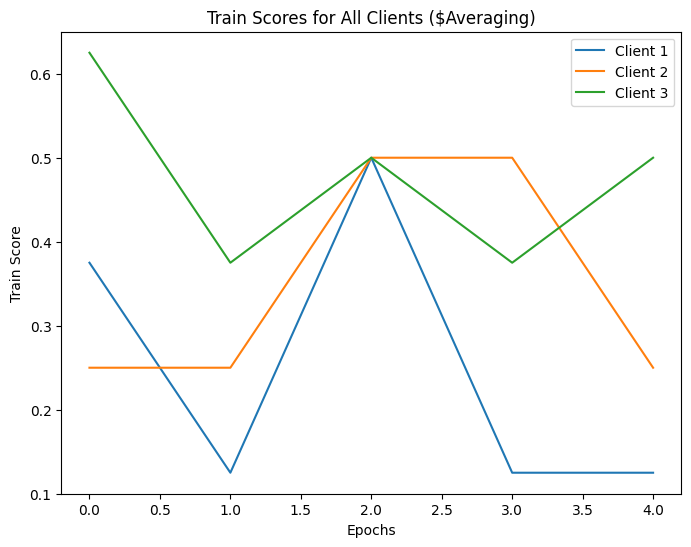

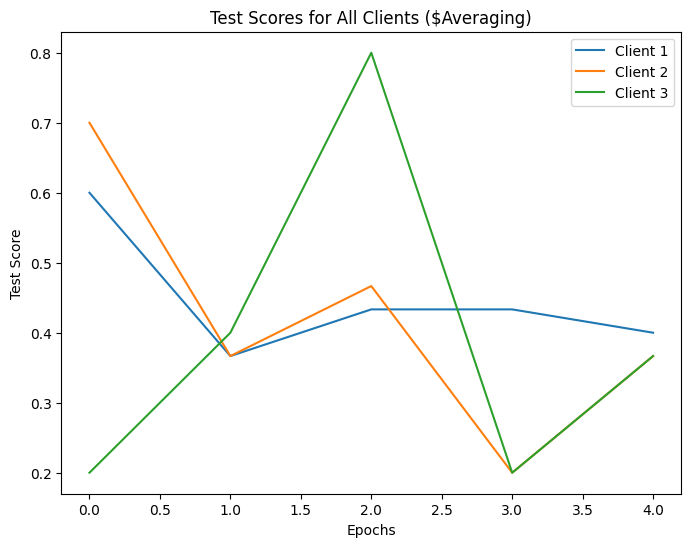

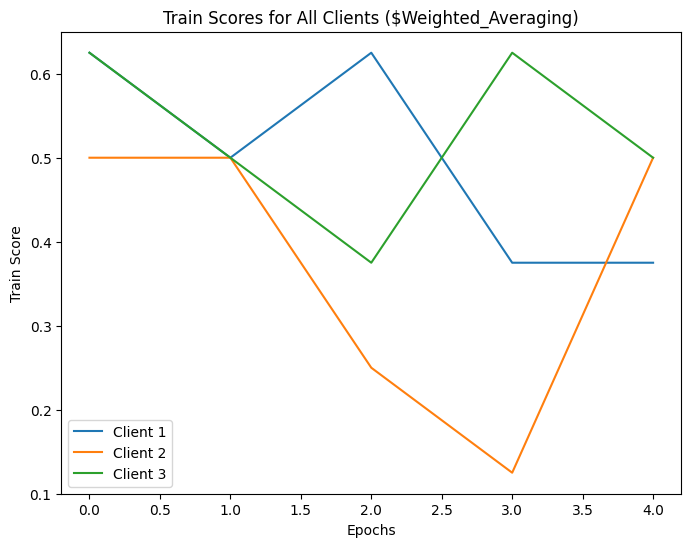

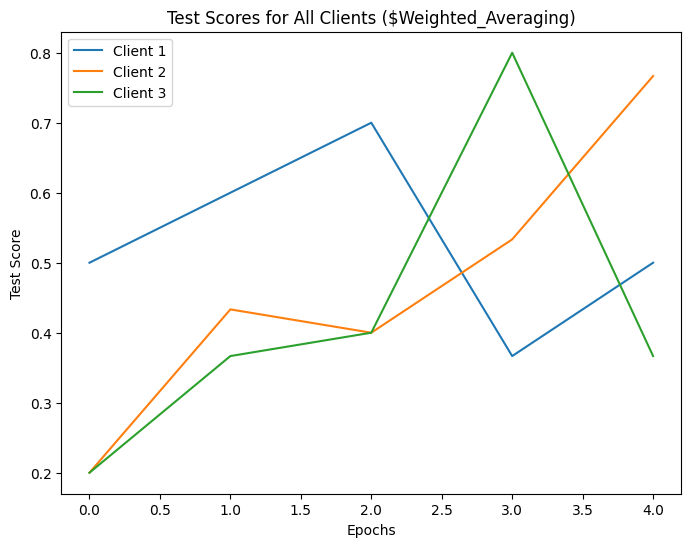

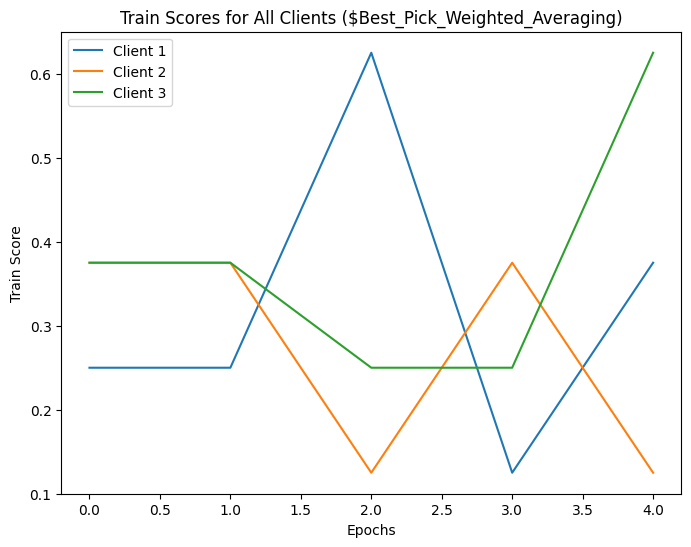

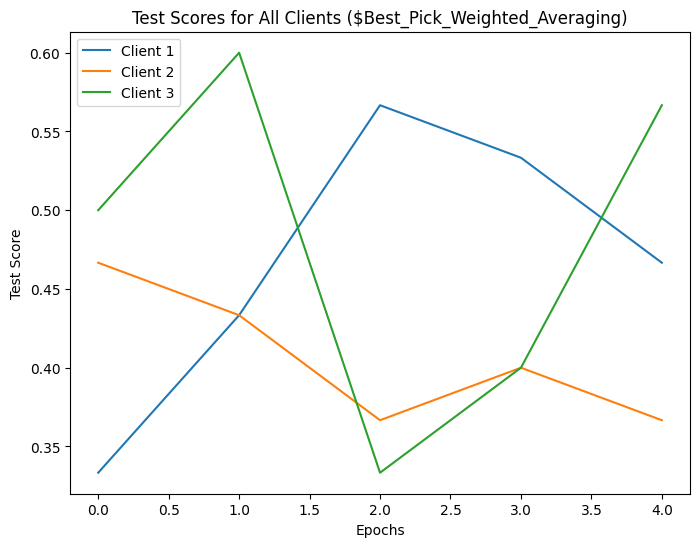

In [98]:
import matplotlib.pyplot as plt

# Create two figures, one for train scores and one for test scores

for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot train scores for all clients
  for client in clients:
      plt.plot(client.train_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Train Score')
  plt.title(f"Train Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the train scores plot
  plt.show()

  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Test Score')
  plt.title(f"Test Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the test scores plot
  plt.show()


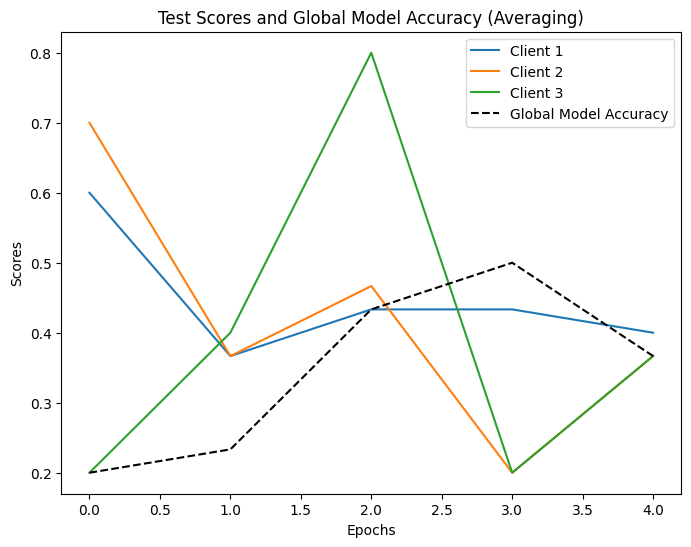

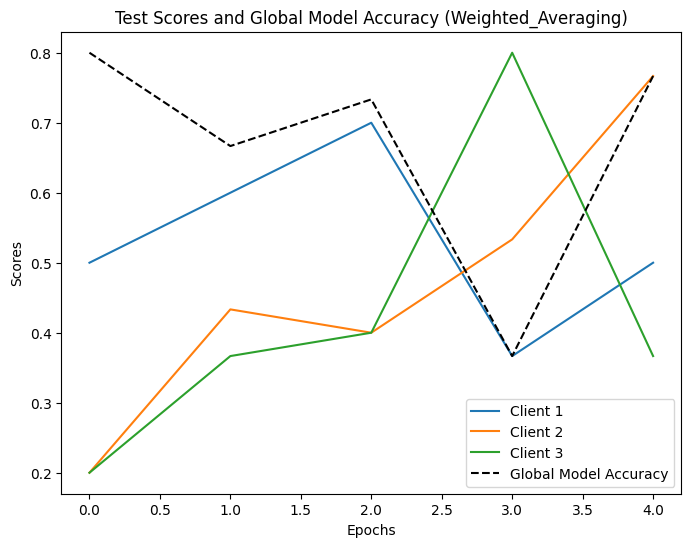

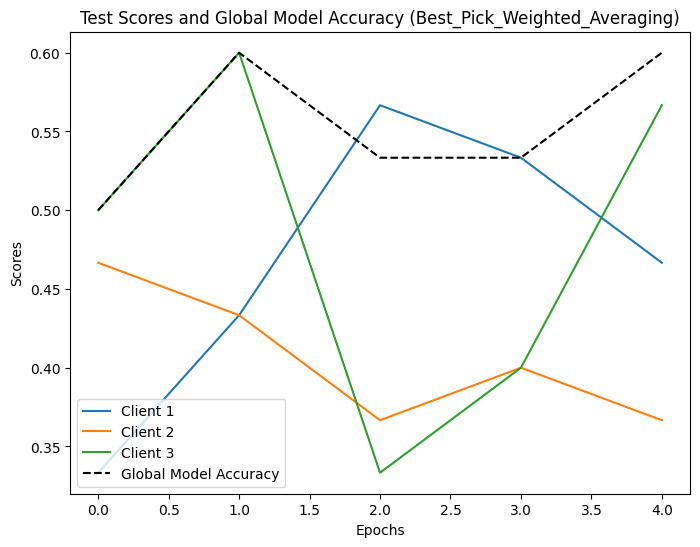

In [99]:
import matplotlib.pyplot as plt


for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))


  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  # Plot global model accuracy
  plt.plot(global_model_accuracy[idx], label='Global Model Accuracy', linestyle='--', color='black')

  plt.xlabel('Epochs')
  plt.ylabel('Scores')
  plt.title(f"Test Scores and Global Model Accuracy ({technique_name})")
  plt.legend()

  # Show the combined graph
  plt.show()


## Federated Learning Training Loop

In this code, we implement the training loop for Federated Learning across multiple epochs and clients. The key steps and processes are as follows:

1. **Epoch-by-Epoch Training**: The code iterates through each epoch, starting with epoch 0, and prepares to train client models for that epoch.

2. **Client Training**: For each epoch, the code goes through all the clients, one by one. It checks if the client has a primary model. If not, it creates a new model and trains the model using the training data specific to that client and epoch. The resulting model is stored in the client's `models` array. The training process also calculates and stores the training and testing scores for each client.

3. **Global Model Aggregation**: After training the models for all clients in a given epoch, the code collects the trained model weights in an array called `epoch_weights`. This array holds the weights of all client models and the global model from the previous epoch (if applicable).

4. **Global Model Averaging**: The code computes the average of the weights in the `epoch_weights` array to create a global model for that epoch. This global model represents a consensus model generated from the weighted combination of client models and the previous global model (if any).
 - To extend the

5. **Client Model Update**: The new global model is assigned to each client as its primary model for the next epoch. This ensures that all clients train using the same global model in the following epoch.

6. **Global Model Evaluation**: The code evaluates the accuracy of the global model on a subset of testing data. The accuracy is stored in the `global_model_accuracy` array for tracking the performance of the global model over different epochs.

The code proceeds to repeat this process for all specified epochs. This iterative training and global model update are essential for Federated Learning, allowing clients to contribute to the global model while maintaining their own local data privacy and model customization.


### Result Visualization: Accuracy and Average Reward

In [100]:
import matplotlib.pyplot as plt

def callback_results(clients, global_model_accuracy, global_model_avg_reward):
    # Create two figures, one for train scores and one for test scores
    plt.figure(figsize=(8, 6))

    # Plot train scores for all clients
    for client in clients:
        plt.plot(client.train_scores, label=f'Client {clients.index(client) + 1}')

    plt.xlabel('Epochs')
    plt.ylabel('Train Score')
    plt.title('Train Scores for All Clients')
    plt.legend()

    # Show the train scores plot
    plt.show()

    # Create a new figure for test scores
    plt.figure(figsize=(8, 6))

    # Plot test scores for all clients
    for client in clients:
        plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

    # Plot global model accuracy
    plt.plot(global_model_accuracy, label='Global Model Accuracy', linestyle='--', color='black')
    plt.xlabel('Epochs')
    plt.ylabel('Test Score')
    plt.title('Test Scores for All Clients')
    plt.legend()

    # Show the test scores plot
    plt.show()

    # Plot average reward for all clients
    for client in clients:
        plt.plot(client.avg_reward, label=f'Client {clients.index(client) + 1}')
    # Plot global model accuracy
    plt.plot(global_model_avg_reward, label='Global Model Average Reward', linestyle='--', color='black')
    plt.xlabel('Epochs')
    plt.ylabel('Average Reward')
    plt.title('Average Reward for All Clients')
    plt.legend()

    # Show the test scores plot
    plt.show()

epoch: 0
Index: 0, Client: <__main__.Client object at 0x0000022CD541B1C0>
Train Sequences Shape: (8, 4)
Train Labels Shape: (8,)
Training Started
action: [2 2 0 0 2 2 2 2]
Loss_5: 0.07823212487704206
logits: [0.41796875 0.43261719 0.40332031 0.39648438 0.40820312 0.42675781
 0.41601562 0.39648438]
reward_avg: 0.875
Score: 0.5
sum_reward: 7.0
action: [2 2 2 2 2 2 2 2]
Loss_5: 0.07613789231161601
logits: [0.53710938 0.57617188 0.484375   0.48632812 0.515625   0.50683594
 0.51171875 0.53222656]
reward_avg: 0.125
Score: 0.36666666666666664
sum_reward: 1.0
action: [2 2 2 2 2 2 2 2]
Loss_5: 0.08155481606533019
logits: [0.70410156 0.81542969 0.78027344 0.79003906 0.82519531 0.86425781
 0.59570312 0.69140625]
reward_avg: 0.125
Score: 0.36666666666666664
sum_reward: 1.0
action: [1 1 2 1 1 1 1 1]
Loss_5: 0.6747788133627605
logits: [0.453125   0.48535156 0.34179688 0.47851562 0.48242188 0.45507812
 0.47949219 0.45410156]
reward_avg: -0.25
Score: 0.26666666666666666
sum_reward: -2.0
action: [2 2 2

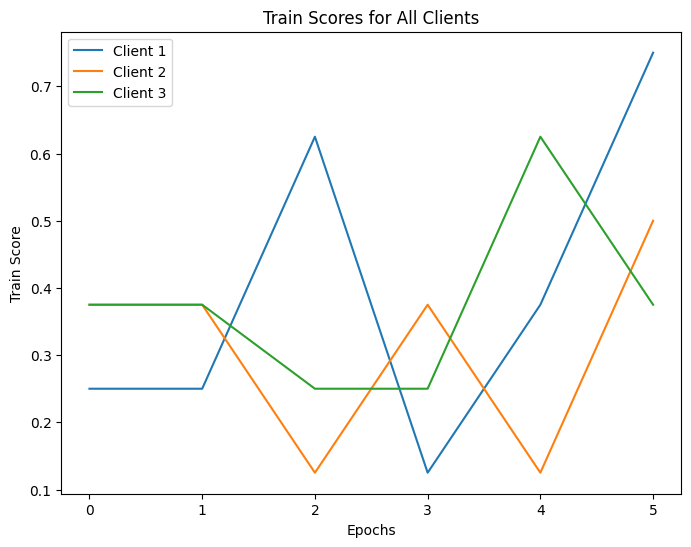

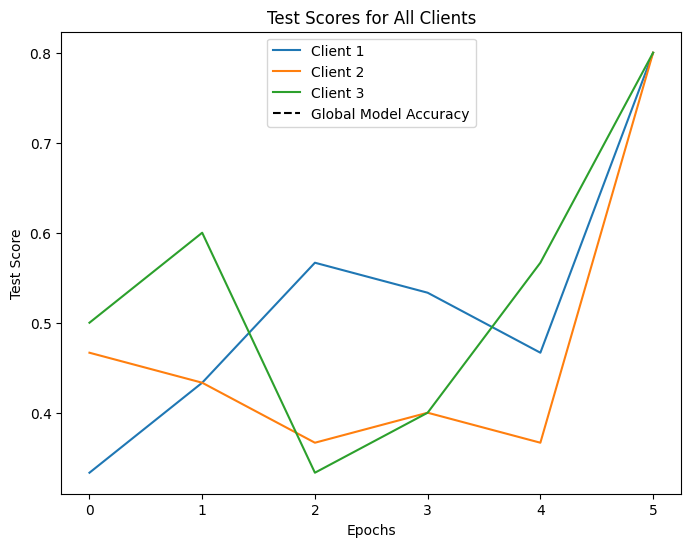

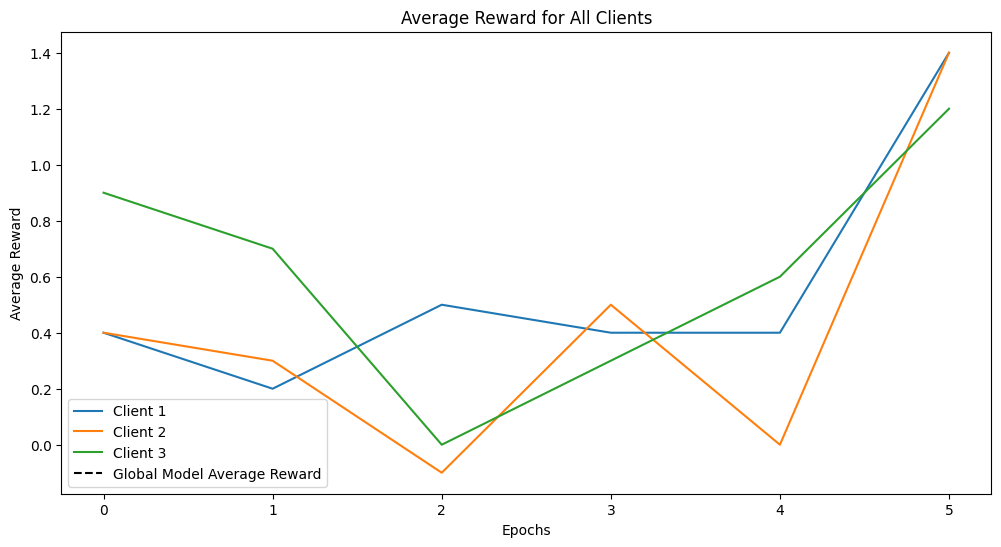

epoch: 1
Index: 0, Client: <__main__.Client object at 0x0000022CD541B1C0>
Train Sequences Shape: (8, 4)
Train Labels Shape: (8,)
Training Started
action: [0 2 1 0 2 2 2 2]
Loss_5: 1.0698515128949793
logits: [0.45117188 0.43457031 0.15625    0.52734375 0.57910156 0.56835938
 0.52441406 0.53125   ]
reward_avg: 1.625
Score: 0.8
sum_reward: 13.0
action: [1 0 1 0 1 1 1 1]
Loss_5: 0.6889106726250303
logits: [0.43457031 0.2734375  0.46582031 0.421875   0.46289062 0.453125
 0.46679688 0.48144531]
reward_avg: -0.25
Score: 0.23333333333333334
sum_reward: -2.0
action: [0 2 2 0 2 2 2 2]
Loss_5: 0.07596543278845068
logits: [0.41894531 0.41503906 0.40429688 0.50195312 0.53125    0.51464844
 0.48242188 0.51953125]
reward_avg: 1.25
Score: 0.8
sum_reward: 10.0
action: [0 1 0 0 1 1 1 1]
Loss_5: 0.5882633823945238
logits: [0.39746094 0.39355469 0.34179688 0.41699219 0.47558594 0.43164062
 0.41796875 0.44824219]
reward_avg: 0.125
Score: 0.6333333333333333
sum_reward: 1.0
action: [2 2 2 2 2 2 2 2]
Loss_5: 

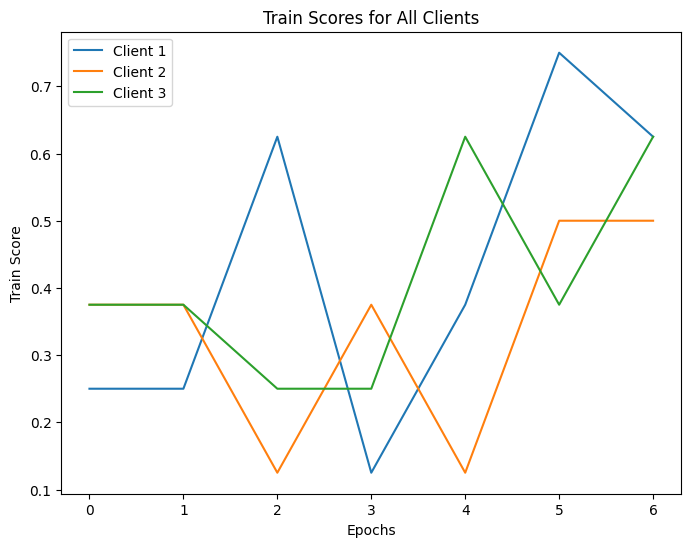

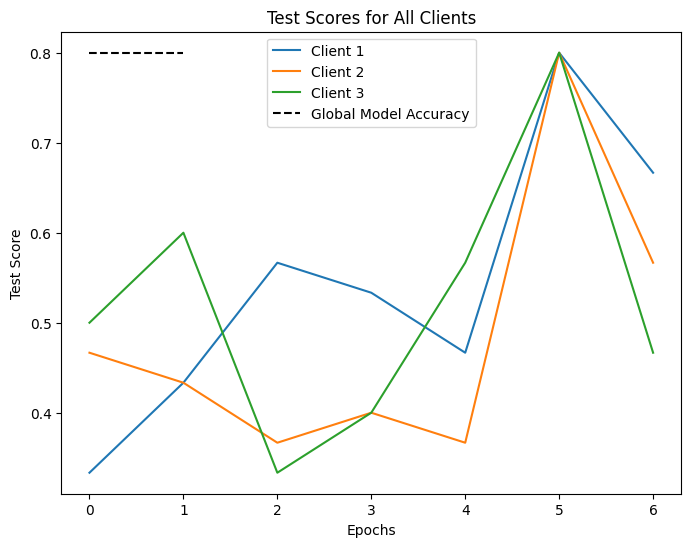

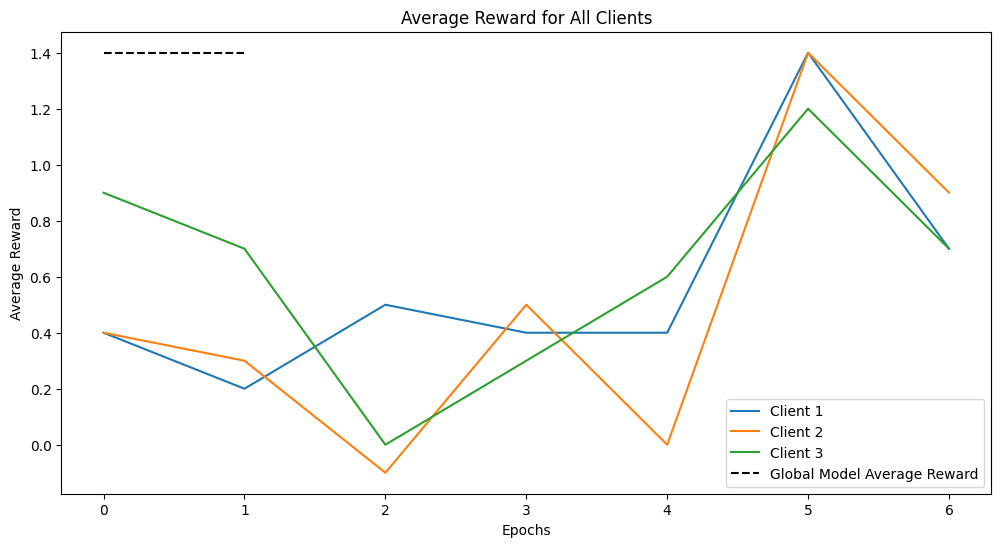

epoch: 2
Index: 0, Client: <__main__.Client object at 0x0000022CD541B1C0>
Train Sequences Shape: (8, 4)
Train Labels Shape: (8,)
Training Started
action: [2 2 0 0 2 2 0 2]
Loss_5: 0.07640627705396638
logits: [0.67578125 0.55566406 0.41894531 0.41113281 0.63476562 0.36914062
 0.4140625  0.55664062]
reward_avg: 0.875
Score: 0.8
sum_reward: 7.0
action: [2 2 1 0 2 1 1 2]
Loss_5: 0.07435571765670833
logits: [0.60742188 0.42480469 0.42675781 0.39355469 0.54785156 0.40527344
 0.40820312 0.47265625]
reward_avg: 0.125
Score: 0.6
sum_reward: 1.0
action: [2 2 0 0 2 0 1 2]
Loss_5: 0.7530969288092443
logits: [0.6640625  0.52148438 0.42382812 0.48242188 0.63085938 0.44628906
 0.17089844 0.55761719]
reward_avg: 0.875
Score: 0.8
sum_reward: 7.0
action: [2 2 0 0 2 0 0 2]
Loss_5: 0.0774607231385719
logits: [0.46875    0.35839844 0.40917969 0.46582031 0.42382812 0.43652344
 0.48925781 0.39453125]
reward_avg: 1.25
Score: 0.8
sum_reward: 10.0
action: [2 2 2 0 2 2 2 2]
Loss_5: 0.07571970541470541
logits: [0

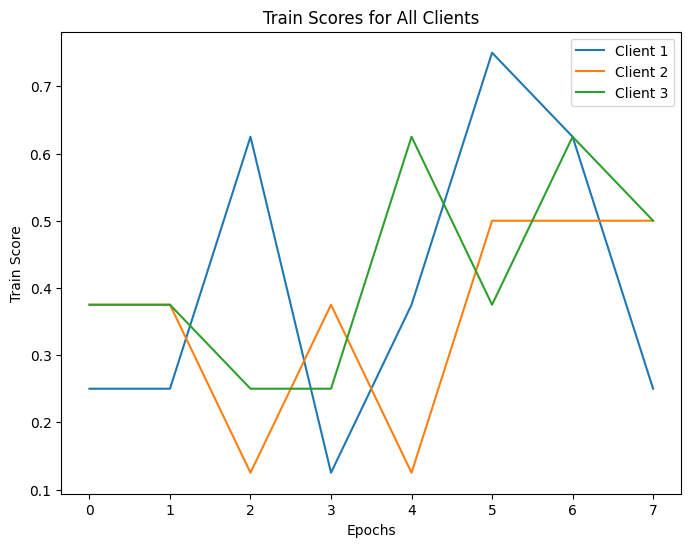

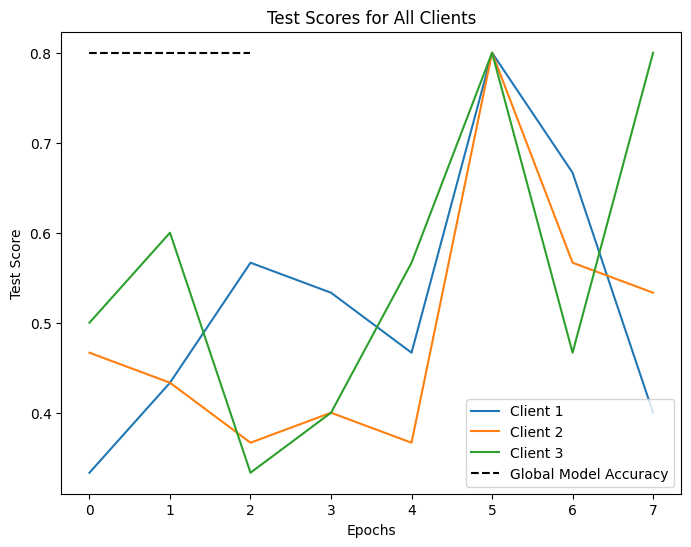

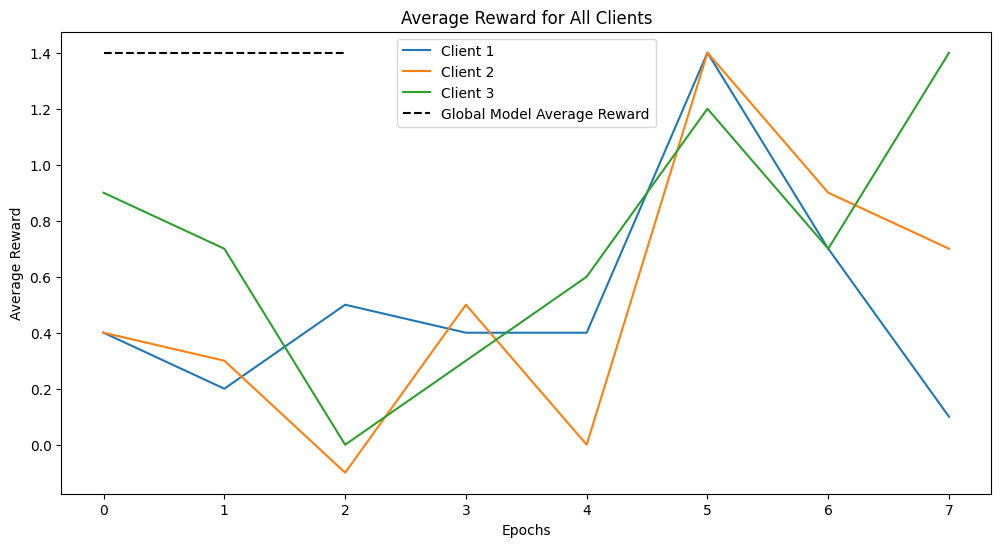

epoch: 3
Index: 0, Client: <__main__.Client object at 0x0000022CD541B1C0>
Train Sequences Shape: (8, 4)
Train Labels Shape: (8,)
Training Started
action: [2 2 2 2 0 2 0 2]
Loss_5: 0.7391136094503253
logits: [0.50195312 0.47070312 0.39648438 0.56640625 0.25195312 0.64355469
 0.453125   0.57421875]
reward_avg: 0.5
Score: 0.7666666666666667
sum_reward: 4.0
action: [2 2 0 2 2 2 0 2]
Loss_5: 0.07375049212931031
logits: [0.3984375  0.36914062 0.36914062 0.48828125 0.42871094 0.546875
 0.47070312 0.56640625]
reward_avg: 0.5
Score: 0.7666666666666667
sum_reward: 4.0
action: [2 2 2 2 2 2 0 2]
Loss_5: 0.07396138954196613
logits: [0.54199219 0.51074219 0.47460938 0.58398438 0.49316406 0.64453125
 0.59960938 0.62207031]
reward_avg: 0.5
Score: 0.8
sum_reward: 4.0
action: [1 1 0 1 1 1 0 1]
Loss_5: 0.07771402527497864
logits: [0.36328125 0.35351562 0.41210938 0.39355469 0.34472656 0.41992188
 0.48828125 0.39453125]
reward_avg: 0.5
Score: 0.6333333333333333
sum_reward: 4.0
action: [2 2 2 2 2 2 2 2]
Lo

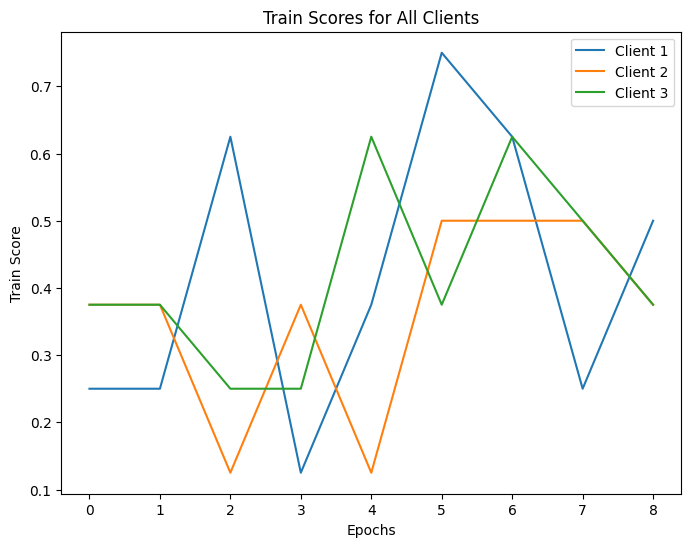

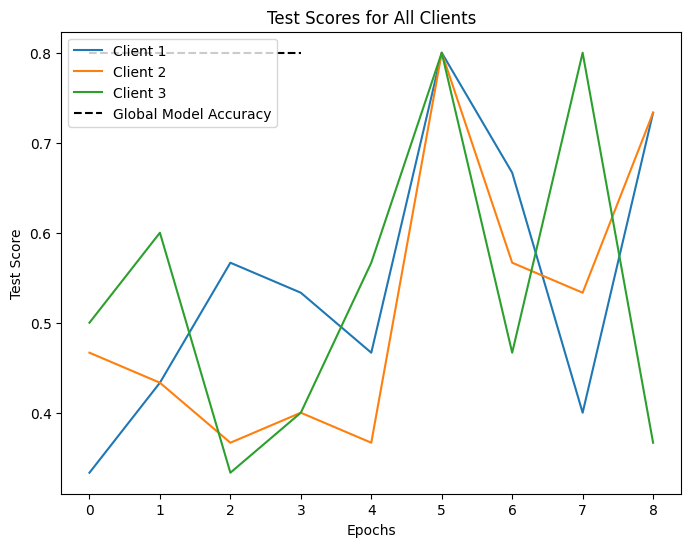

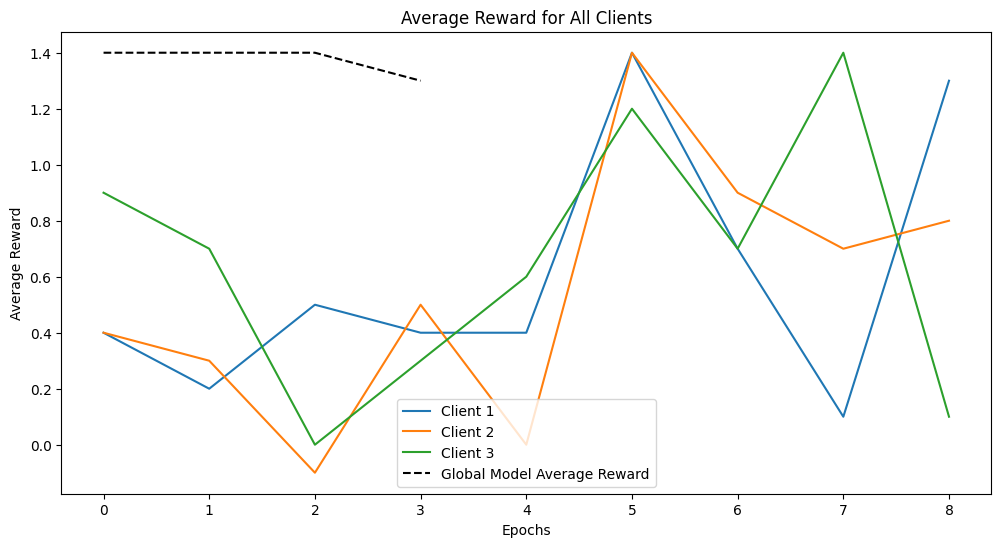

epoch: 4
Index: 0, Client: <__main__.Client object at 0x0000022CD541B1C0>
Train Sequences Shape: (8, 4)
Train Labels Shape: (8,)
Training Started
action: [0 0 0 2 0 2 2 0]
Loss_5: 0.07676022030262619
logits: [0.40136719 0.51757812 0.54101562 0.42382812 0.41210938 0.44238281
 0.42089844 0.50195312]
reward_avg: 1.25
Score: 0.8
sum_reward: 10.0
action: [2 0 0 0 2 2 2 0]
Loss_5: 0.7473378457697631
logits: [0.49121094 0.41113281 0.46191406 0.27441406 0.50488281 0.55175781
 0.546875   0.41894531]
reward_avg: 0.875
Score: 0.8
sum_reward: 7.0
action: [0 2 0 2 0 2 1 0]
Loss_5: 1.3466350459243799
logits: [0.49707031 0.38378906 0.59375    0.45410156 0.47460938 0.4609375
 0.22851562 0.54882812]
reward_avg: 0.5
Score: 0.8
sum_reward: 4.0
action: [1 0 0 1 1 1 1 0]
Loss_5: 0.0797649789383904
logits: [0.45410156 0.42675781 0.47460938 0.52734375 0.42089844 0.54003906
 0.59667969 0.43945312]
reward_avg: 0.875
Score: 0.6333333333333333
sum_reward: 7.0
action: [2 2 2 0 2 2 2 2]
Loss_5: 0.8186465588524316


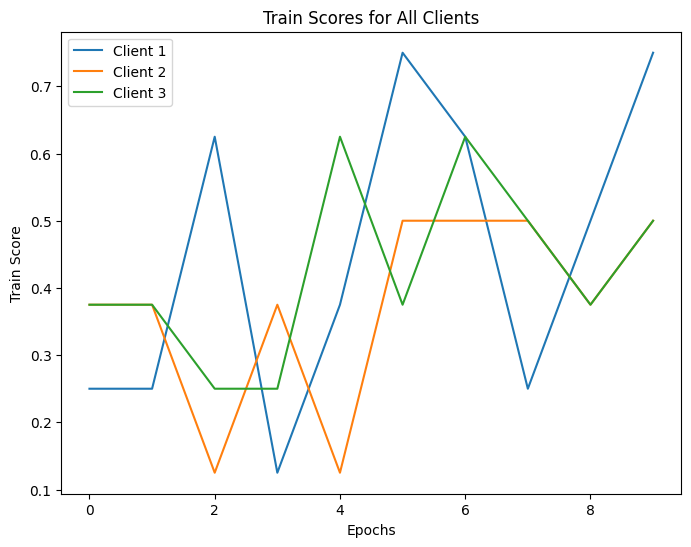

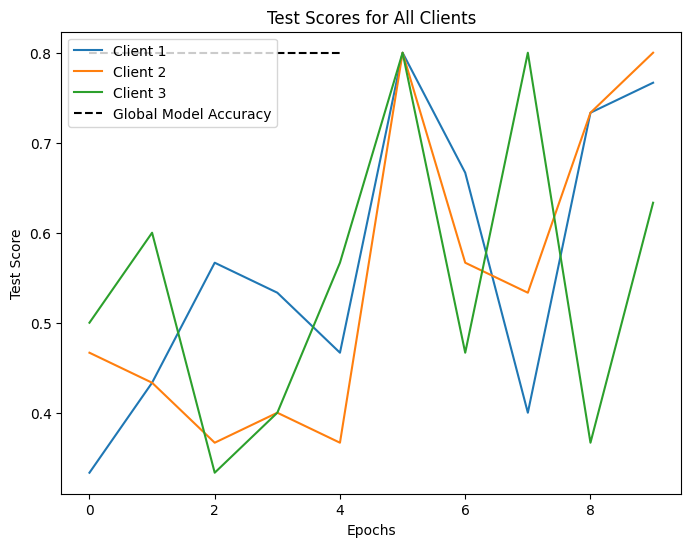

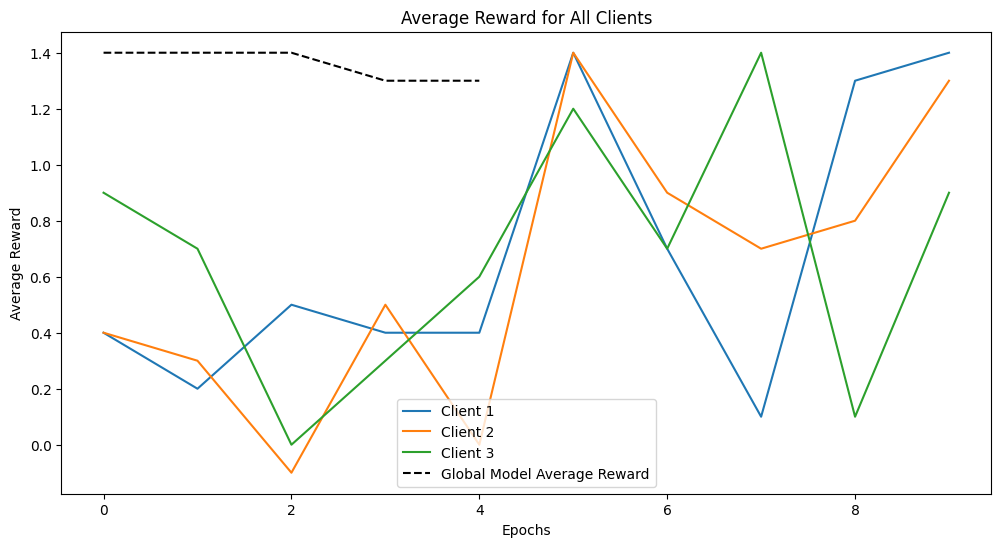

In [101]:
global_model_weights = {}
global_model_accuracy = []
global_model_avg_reward = []

for epoch in range(num_epochs):
  global_model_weights[epoch] = []
  epoch_weights = []
  print(f"epoch: {epoch}")

  for index, client in enumerate(clients):
    print(f"Index: {index}, Client: {client}")

    objective_func_vals = []
    
    if client.primary_model is None:
      train_score_q, test_score_q, model = train(data = client.data[epoch])
      avg_reward = getAvgReward(model.weights)
      client.models.append(model)
      client.test_scores.append(test_score_q)
      client.train_scores.append(train_score_q)
      client.avg_reward.append(avg_reward)
      
      # Print the values
      print("Train Score:", train_score_q)
      print("Test Score:", test_score_q)
      print("\n\n")
      epoch_weights.append(model.weights)

    else:
      train_score_q, test_score_q, model = train(data = client.data[epoch], model = client.primary_model)
      avg_reward = getAvgReward(model.weights)
      client.models.append(model)
      client.test_scores.append(test_score_q)
      client.train_scores.append(train_score_q)
      client.avg_reward.append(avg_reward)
      print("Train Score:", train_score_q)
      print("Test Score:", test_score_q)
      print("\n\n")
      epoch_weights.append(model.weights)

  if(epoch != 0):
    epoch_weights.append(global_model_weights[epoch-1])

  average_weights = sum(epoch_weights) / len(epoch_weights)

  global_model_weights[epoch] = average_weights
  new_model_with_global_weights = create_model_with_weights(global_model_weights[epoch])
  for index, client in enumerate(clients):
    client.primary_model = new_model_with_global_weights

  global_accuracy = getAccuracy(global_model_weights[epoch])
  global_avg_rewatd = getAvgReward(global_model_weights[epoch])
  print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
  print(f"Global Model Avg Reward In Epoch {epoch}: {global_avg_rewatd}")
  print("----------------------------------------------------------")
  global_model_accuracy.append(global_accuracy)
  global_model_avg_reward.append(global_avg_rewatd)
  callback_results(clients,global_model_accuracy,global_model_avg_reward)
  